# Analysing molecular dynamics simulations

> _Original Author:_ Giacomo Meanti — [Giodiro](https://github.com/Giodiro)
> _Modified by:_ Grégoire Pacreau

In this tutorial we will do a simple spectral analysis of a molecular dynamics simulation of the alanine dipeptide.
This small molecule is often used as a test bench for algorithms working on MD since it provides interesting, slow dynamics while being small and easy to work with.

We will start by training a Nystroem reduced rank regression model with the `kooplearn.models.NystroemKernel` class and a Gaussian kernel, and from there move to the spectral analysis of eigenvalues and eigenfunctions of the estimated Koopman operator.

Using the Nystroem approximation allows us to run a full analysis of MD data in a few seconds, without needing to subsample the trajectories too much (we will be training models on 25k and 50k points in a matter of seconds).

## Setup

In [1]:
import importlib

for module in ['kooplearn', 'matplotlib']:
    try:
        importlib.import_module(module)
    except ImportError:
        %pip install {module}

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from urllib.request import urlretrieve
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.gaussian_process.kernels import RBF
from kooplearn.models import NystroemKernel, Kernel
from kooplearn.data import traj_to_contexts

### Download the data

The data consists of 3 250ns long independent molecular dynamic runs of the alanine dipeptide.
The first file contains the backbone dihedral angles $\phi, \psi$. They are known to provide enough information to identify 
the slow transitions of the dipeptide.

We will not use the dihedrals for training but only for the subsequent analysis: 
we will show that a model trained on the heavy atom pairwise distances (contained in the second file we're downloading)
can recover the same slow transitions as can be done by analyzing the dihedrals.

In a more realistic example, one would not have access to the dihedrals but would still be interested in recovering
slow transitions of the molecule.
 
For more information about the data, see https://markovmodel.github.io/mdshare/ALA2/#alanine-dipeptide


In [3]:
base_url = "http://ftp.imp.fu-berlin.de/pub/cmb-data/"
files = [
    "alanine-dipeptide-3x250ns-backbone-dihedrals.npz",
    "alanine-dipeptide-3x250ns-heavy-atom-distances.npz",
]
for file in files:
    if not os.path.isfile(file):
        urlretrieve(base_url + file, file)

We will use the first of three simulations for training and the second for testing. We will also subsample the data to reduce the dataset.

In [5]:
train_distances = np.load(files[1])["arr_0"]
test_distances = np.load(files[1])["arr_1"]
test_dihedrals = np.load(files[0])["arr_1"]
time_ns = np.arange(train_distances.shape[0], dtype=np.float64)*1e-3

subsample = 20

**Question 1.** Create the atom distance and the Ramachandran plot (the angle $\phi$ and $\psi$ of backbone dihedral against each other). Notice the clusters, they define the states in which the protein can be.

In [6]:
#reduced rank = True --> RRR

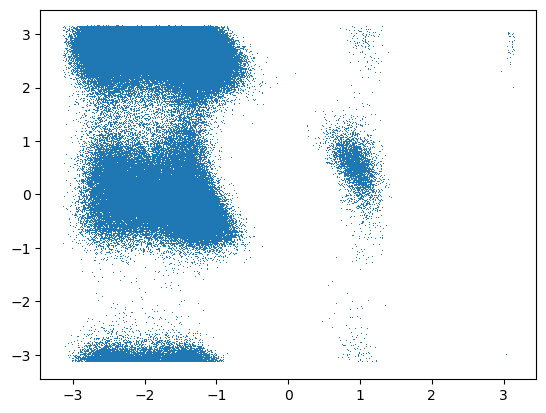

In [16]:
plt.plot(test_dihedrals[:,0],test_dihedrals[:,1],',')

## Model training

**Question 2.** Build contextsGenerate the following arrays:
 - `tr_dist_ctx`: the training context (x and y). This uses atom distances
 - `ts_dist_ctx`: the test context (x and y) using atom distances
 - `ts_dih_ctx`: an auxiliary *test* context which contains dihedrals instead of atom distances

In [62]:
#tr_dist_ctx = traj_to_context(train_distances,context_window_len=3)
tr_dist_ctx = traj_to_contexts(train_distances[::20,:],time_lag=10)
ts_dist_ctx = traj_to_contexts(test_distances[::20,:],time_lag=10)
ts_dih_ctx = traj_to_contexts(test_dihedrals[::20,:],time_lag=10)

**Question 3.** We will use the RBF kernel for our analysis. Give the equation of that kernel. Take some (less than 50) samples in the training set and compute the proximity matrix using this kernel and length scale parameter ranging from $10^{-3}$ to $10$. What do you deduce on the influence of the length scale parameter?

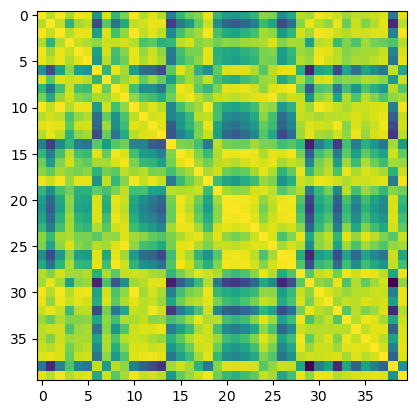

In [63]:
kernel = RBF(length_scale=0.5)
#prox_mat = kernel(train_distances[::20])
prox_mat = kernel(train_distances[:40,:])
plt.imshow(prox_mat)

For the rest of the exercise we will take a length scale of $0.5$. Knowing that the kernelDMD needs to compute the distance matrix for the full training dataset, we will use the Nyström approximation to accelerate training.

**Question 4.** Build the Nyström reduced rank regression (N-RRR) model used for training. 
Important hyperparameters are:
 - The kernel, here a Gaussian (RBF) kernel with length-scale 0.5. You can use any other kernels supported by scipy to compare performances.
 - `reduced_rank`, an option to switch between kernel ridge regression and reduced rank regression, we will set it to True.
 - The regularizer `tikhonov_reg`, should be a small positive number to ensure a stable solution.
 - The rank of the model to be trained: this depends on the system being analyzed. Note that rank gives the number of eigenvalues the system keeps.
 - The number of Nyström centers. Increasing this parameter makes the model slower to train but also more accurate. We will set this parameter around 500.
 
Fit the estimator for different values for the tikhonov_reg and rank and compare the RMSEs by running predictions on the test set. You should achieve a RMSE below 0,050. Try to fit the estimator with a kernel having a length scale of $10^{-3}$ and $100$. What do you observe?

In [73]:
ts_dist_ctx.shape

(12490, 2, 45)

In [79]:
nys_rrr = NystroemKernel(kernel=kernel,reduced_rank=True,tikhonov_reg=1e-8,rank=5,num_centers=500)
nys_rrr.fit(tr_dist_ctx)
pred = nys_rrr.predict(ts_dist_ctx)
true = ts_dist_ctx.lookforward(NRRR.lookback_len)
rmse = np.sqrt((np.sum((pred-true)**2)))/ts_dist_ctx.shape[0]

print(rmse)






"""
print('ls = 0.5 rmse : ', rmse)
kernel = RBF(length_scale=1e-3)
NRRR = NystroemKernel(kernel=kernel,reduced_rank=True,tikhonov_reg=1e-8,rank=5,num_centers=500)
NRRR.fit(tr_dist_ctx)
pred = NRRR.predict(ts_dist_ctx)
rmse = np.sqrt((np.sum((pred-ts_dist_ctx)**2)))/ts_dist_ctx.shape[0]
print('ls = 0.5 rmse : ', rmse)
"""

0.0018015233411066694


"\nprint('ls = 0.5 rmse : ', rmse)\nkernel = RBF(length_scale=1e-3)\nNRRR = NystroemKernel(kernel=kernel,reduced_rank=True,tikhonov_reg=1e-8,rank=5,num_centers=500)\nNRRR.fit(tr_dist_ctx)\npred = NRRR.predict(ts_dist_ctx)\nrmse = np.sqrt((np.sum((pred-ts_dist_ctx)**2)))/ts_dist_ctx.shape[0]\nprint('ls = 0.5 rmse : ', rmse)\n"

## Spectral Analysis

Given the Koopman operator we've learned with Nystroem RRR we can analyze the dynamical system.

To do this we will use the **spectrum** of the operator: the eigenvalues and eigenvectors.

Each eigenpair describes a different component of the dynamics. Eigenvalues provide information about the *relaxation time-scales* of each component, larger eigenvalues correspond to slower processes, while smaller ones correspond to faster processes. On the other hand eigenvectors describe how each component varies in space. A common way to use the eigenvectors is to provide a dimensionality reduction of the original (high-dimensional) states onto the **slowest dynamics** corresponding to the eigenvectors with highest eigenvalues.

A special mention to the highest eigenpair which should have eigenvalue close to 1. This is the stationary dynamics, and is generally not used for spectral analysis.

First we use the `nys_rrr` object to compute the eigenvalues of the operator, and the eigenvectors.
Note that since the Koopman operator is technically an *infinite dimensional operator* it doesn't have eigenvectors but **eigenfunctions**. For this reason, in order to have a concrete, finite-dimensional representation, the eigenfunctions must be evaluated on some data-points. Here we evaluate the right eigenfunctions on the subsampled test distances. Here it doesn't really matter if you're using the `X` or `Y` part of the data.

Another thing to note is that the eigenvalues are returned in ascending order. You will have to reverse the order to simplify the analysis later (since we're most interested in the highest eigenvalues!)

**Question 5.** Using the eig method of our estimator, select the first four eigenvalues. 
Derive the time scales implied by the eigenvalues. 
Is the first eigenvalue relevant for our analysis? Try to play with the rank parameter of the model and observe the decay of the time scales.

In [82]:
#modulus of eigenvalue gives an idea about hwo fast it disappears
#argument --> gives the frequency of the signal 
#the bigger the eigenvalue, the longer the state remains
#we have pairs only for the eigenvalues that are complex, for the real eigenvalues, we don't have pairs. 
"""
evals, evec_right = nys_rrr.eig(eval_right_on=ts_dist_ctx)
top_evals
"""

**Question 6.** We now have to take into account the fact that we've subsampled the data, and that we have generated trajectories such that the Koopman operator predicts Y from X where the pairs are `time_lag` time-steps apart. Knowing that the trajectories have a time-step of 1ps, compute the implied time-scales.

Note that:
 - we exclude the top eigenvalue (which corresponds to the stationary distribution), since it theoretically has an infinite relaxation time-scale
 - the spectrum for this system decays very rapidly as there are only two or three slow components to the dynamics. Since the other components are much faster, their true eigenvalues are very close to 0. The learned estimator will have some small errors due to having access to a finite dataset, so these eigenvalues might be estimated to be slightly lower than zero which causes them to have an **undefined time-scale**.

In [83]:
print(test_list)

[0.00788351-0.006567j 0.00788351+0.006567j 0.06602841+0.j
 0.81861812+0.j       0.99999003+0.j      ]


**Question 7.** Finally, we're going to plot the first three eigenfunctions (excluding the stationary distribution) on the test data. We will superimpose the eigenfunctions, which in the plot below are represented with as the color, to the Ramachandran plot.
Since we know that the Ramachandran plot provides a good clustering of the dynamics of the alanine dipeptide, we wish to see whether the color (eigenfunctions) also matches the clusters well.

By matching each eigenfunction to an eigenvalue we will also learn which transition between different areas of the Ramachandran plot is slowest.

**Question 8.** Comment on the clusters. If some plots are duplicated, what explanation can you find?

## Consistency Analysis

An important aspect of a spectral analysis is that it should remain consistent across different time-lags.

We will analyze the implied time-scale (ITS) in terms of number of simulation steps (thus ignoring the real units of the simulation and the subsampling).

As we train models with increasing time lags (the time lag is the distance in number of simulation steps between x and y pairs), the estimated eigenvalues will become smaller since the model's time-unit is the single time-lag, and relaxation becomes faster in terms of # of time-lags. However the ITS should remain relatively stable.

As we increase the time lags even further, faster dynamics will have relaxation times which are faster than a single time-lag, hence the model won't be able to estimate those reliably.

We will see that the 1st ITS increases rapidly as we start increasing the time lags. This behavior is well documented in similar models. At some point however it converges, much before it becomes too fast to be resolved.

The 2nd ITS instead is much smaller, hence it won't be resolved with higher time-lags. However we find that it converges very quickly at small time-lags.

**Question 9.** Define a helper function to train a model and return its ITS and test RMSE at a specific time-lag.

**Question 10.** Train one model per time-lag in a list going from 1 to 100. Note that since the Nystroem method is very efficient we can quickly train many models even with many time-points (subsample=5 means training with 50k points). Plot the RMSE and ITS for the different time lags.